In [ ]:
# Connect to save data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MNIST Dataset

In [ ]:
!pip install -U dm-haiku
!pip install torch torchvision
batch_size = 64
n_targets = 10
# TODO might need to initialize model inside train_model function, this way
# we can change the initial parameters, right now everything is initialized with same RNG

     |████████████████████████████████| 309 kB 5.2 MB/s 


In [ ]:
import haiku as hk
import jax
import jax.numpy as jnp
from jax import jvp, random
rng = jax.random.PRNGKey(412)

# Dataloader

In [ ]:
#import jax.numpy as np
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST, CIFAR10
import torchvision

def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    # IMPORTANT: make all pixels between 0 and 1, this makes training much more stable!
    # could do one better here and fully normalize as well, I just haven't bothered to do that yet
    return np.array(pic, dtype=jnp.float32) / 255 

# Loss, Accuracy, Fgd

In [ ]:
def softmax_cross_entropy(logits, labels):
  one_hot = jax.nn.one_hot(labels, logits.shape[-1])
  return -jnp.sum(jax.nn.log_softmax(logits) * one_hot, axis=-1)

  
def stateful_loss_fn(params, state, model, images, labels, is_training):
  logits, state = model.apply(params, state, images, is_training) 
  return jnp.mean(softmax_cross_entropy(logits, labels)), state

def perturb(params, key):
  params, treedef = jax.tree_flatten(params)
  perts = []
  for param in params:
    key, _ = random.split(key)
    perts.append(random.normal(key, param.shape)) 
  return jax.tree_unflatten(treedef,perts)

def update(update, v, dir, step_size):
  return update - step_size * v * dir

def stateful_fgd(model, params, state,  images, targets, key):
  f = lambda W: stateful_loss_fn(W, state, model, images, targets, is_training=True)
  v = perturb(params, key)
  L, u, state = jvp(f, (params,), (v,), has_aux=True)
  return L, v, u, state #loss, perturbation, forward gradient 

def stateful_accuracy(model, params, state, images, targets, ):
  target_class = jnp.argmax(targets, axis=1)
  out, _ = model.apply(params, state, images, is_training=False)
  predicted_class = jnp.argmax(out, axis=1)
  return jnp.mean(predicted_class == target_class)

def stateful_backprop(loss_fn, params, state, images, targets):
  (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, images, targets, )
  # dummy variables so that this works with the below train_model function
  return loss, grads, 1, state #loss, grads


# Collect Metrics

In [ ]:
def init_metrics():
    metrics = {
      "loss": [],
      "step_size": [],
      "train_acc": [],
      "test_acc": [],
      "epoch_time": []  
  }
    return metrics

def collect_metrics(metrics, loss, step_size, train_acc, test_acc, epoch_time):
    metrics["loss"].append(loss)
    metrics["step_size"].append(step_size)
    metrics["train_acc"].append(train_acc)
    metrics["test_acc"].append(test_acc)
    metrics["epoch_time"].append(epoch_time)
    return metrics

# Optimizers

In [ ]:
@jax.jit
def sgd(params, v, u, step_size):
    return jax.tree_map(lambda param, v: update(param, v, u, step_size), params, v)

def initialize_moments(params):
  params, treedef = jax.tree_flatten(params)
  s = []
  r = []
  for param in params:
    s.append(jnp.zeros_like(param))
    r.append(jnp.zeros_like(param))
  return jax.tree_unflatten(treedef, s), jax.tree_unflatten(treedef, r)


@jax.jit
def adam_update(params, g, step_size, s, r, t, b1=0.9, b2=0.999, eps = 1e-8):
  #Args: Parameters, step_size, s, r (moment variables), timestep
  
  params, treedef = jax.tree_flatten(params)
  g, _ = jax.tree_flatten(g)
  s, treedef2 = jax.tree_flatten(s)
  r, treedef3 = jax.tree_flatten(r)
  new_s = []
  new_r = []
  new_params = []
  for param, _g, _s, _r in zip(params, g, s, r):
    s = b1 * _s + (1-b1) * _g
    r = b2 * _r + (1-b2) * (jnp.multiply(_g, _g))
    m = _s * (1/(1-(b1 ** t)))
    v = _r * (1/(1-(b2 ** t)))
    v = jnp.reciprocal(jnp.sqrt(v) + eps * jnp.ones_like(v))
    new_s.append(s)
    new_r.append(r)
    new_params.append(param - step_size * jnp.multiply(m,v))
  return jax.tree_unflatten(treedef2, new_s), jax.tree_unflatten(treedef3, new_r), jax.tree_unflatten(treedef, new_params) 

# Training

### ADAM 

In [ ]:
# ADAM
import time
import sys
def train_model_adam(fgd, model, step_size, num_epochs, training_generator, train_data, test_data, key=None):
  train_images, train_labels = train_data["data"], train_data["labels"]
  test_images, test_labels = test_data["data"], test_data["labels"]
  dummy_image, dummy_label = train_images[0].astype(float)[None, :], train_labels[0].astype(float)

  k = 10e-4
  if key == None:
    key = random.PRNGKey(1025)
  params, state =  model.init(rng, dummy_image, True)
  metrics = init_metrics()

  s, r = initialize_moments(params)
  t = 0
  for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in training_generator:
      t += 1
      next, key = random.split(key)
      L, v, u, state = fgd(params, state, x, y, next)
      g = jax.tree_map(lambda _v: _v * u, v)
      #Begin adam sequence
      s, r, params = adam_update(params, g, step_size, s, r, t)
    step_size *= jnp.exp(-k)
    epoch_time = time.time() - start_time

    train_acc = stateful_accuracy(model, params, state, train_images / 255 , train_labels)
    test_acc = stateful_accuracy(model, params, state, test_images / 255, test_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training loss {} ".format(L))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))
    print("Step size {}".format(step_size))

    collect_metrics(metrics, L, step_size, train_acc, test_acc, epoch_time)
  return params, metrics


### Stateful training with SGD

In [ ]:
def stateful_train_model(fgd, model, step_size, num_epochs, training_generator, train_data, test_data, key=None):
  train_images, train_labels = train_data["data"], train_data["labels"]
  test_images, test_labels = test_data["data"], test_data["labels"]
  dummy_image, _ = train_images[0].astype(float)[None, :], train_labels[0].astype(float)
  k = 10e-4
  if key == None:
    key = random.PRNGKey(1025)
  params, state =  model.init(rng, dummy_image, True)
  metrics = init_metrics()

  # ===== Actual Training Code =====
  for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in training_generator:
      next, key = random.split(key)
      L, v, u, state = fgd(params, state, x, y, next)
      params = sgd(params, v, u, step_size)

    step_size *= jnp.exp(-k)
    epoch_time = time.time() - start_time

    train_acc = stateful_accuracy(model, params, state, train_images / 255 , train_labels)
    test_acc = stateful_accuracy(model, params, state, test_images / 255, test_labels)

    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training loss {} ".format(L))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))
    print("Step size {}".format(step_size))
  # ================================= 

    collect_metrics(metrics, L, step_size, train_acc, test_acc, epoch_time)

  return params, metrics


#Graphs

In [ ]:
import pickle

def save_data(obj, filename):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)

def load_data(filename):
  with open(filename, 'rb') as f: 
    return pickle.load(f)

%mkdir -p /content/csc413/proj/data
%cd /content/csc413/proj/data

path = '/content/csc413/proj/data/'

/content/csc413/proj/data


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import files
def format_time_to_x(times):
  x_times = []
  curr = 0
  for i in range(len(times)):
    curr += times[i]
    x_times.append(curr)
  return x_times

def plot_axes(axs, metric, color, label=None):
  epoch_times = format_time_to_x(metric["epoch_time"])
  N = len(epoch_times)
  axs[0].plot(np.arange(0, N), metric["loss"], color=color)
  axs[1].plot(np.arange(0, N), metric["test_acc"], color=color)
  axs[2].plot(epoch_times, metric["loss"], color=color)
  if label:
    axs[3].plot(epoch_times, metric["test_acc"], color=color, label=label)
  else:
    axs[3].plot(epoch_times, metric["test_acc"], color=color)

def plot_axs_label(axs):
  axs[0].set_ylabel("Loss")
  axs[1].set_ylabel("Test Accuracy")
  axs[2].set_ylabel("Loss")
  axs[3].set_ylabel("Test Accuracy")
  axs[0].set_xlabel("Epoch Num")
  axs[1].set_xlabel("Epoch Num")
  axs[2].set_xlabel("Time")
  axs[3].set_xlabel("Time")


# exps is the output from run_experiments:
# dictionary of form "model_name:" [list of metrics for a number of runs]
def graph_experiments(exps, colors=None, has_axs_lables=True, graph_name=None):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    if colors == None:
      prop_cycle = plt.rcParams['axes.prop_cycle']
      colors = prop_cycle.by_key()['color']

    for i, (name, metric_list) in enumerate(exps.items()):
      # plots for single experiment
      n_runs = len(metric_list)
      plot_axes(axs, metric_list[0], colors[i], name)
      for j in range(1, n_runs):
        plot_axes(axs, metric_list[j], colors[i])

    if has_axs_lables:
      plot_axs_label(axs)
      axs[3].legend()

    if not graph_name:
      plt.show()
    else:
      plt.savefig(graph_name)
      files.download(graph_name) 


In [ ]:
# One-click training function

# t_args: training_generator, train_data, test_data, number of runs for each model
# m_args_list: list of model arguments
def run_experiment(t_args, m_args_list, file_name=None, graph_name=None):
  training_generator, train_images, test_images =  t_args["training_generator"], t_args["train_data"], t_args["test_data"]
  metrics_dict = {}

  # Run the experiment with all the models
  # TODO: if we want to run a model multiple time we need to reinitialize params and change key
  for m in m_args_list:
    metrics = []
    for i in range(t_args["runs"]):
      print(f" ==================== Training {m['model_name']} {i} ==================== ")
      params, run_metrics = m["train_func"](m["grad_func"], m["model_func"], m["lr"], m["epochs"], training_generator, train_images, test_images)
      metrics.append(run_metrics)
    metrics_dict[m["model_name"]] = metrics

  # Graph the models
  if file_name:
    save_data(metrics_dict, path + file_name) # save it for testing graphs w/o rerunning exps
  graph_experiments(metrics_dict, colors=None, has_axs_lables=True, graph_name=graph_name)

# Datasets 

### MNIST 

In [ ]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=lambda img: FlattenAndCast()(img)[:, :, None])
mnist_training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

#train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
mnist_train_images = np.array(mnist_dataset.train_data).reshape((-1, 28, 28, 1))
mnist_train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)
mnist_train_data = { "data": mnist_train_images, "labels": mnist_train_labels}
# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
mnist_test_images = jnp.array(mnist_dataset_test.test_data.numpy().astype(jnp.float32)).reshape((-1, 28, 28, 1))
mnist_test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)
mnist_test_data = { "data": mnist_test_images, "labels": mnist_test_labels}


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### CIFAR10

In [ ]:
# # Define our dataset, using torch datasets
cifar_dataset = torchvision.datasets.CIFAR10('/tmp/cifar/', download=True, transform=FlattenAndCast())
cifar_training_generator = NumpyLoader(cifar_dataset, batch_size=batch_size, num_workers=0)
cifar_train_images = np.array(cifar_dataset.data)
cifar_train_labels = one_hot(np.array(cifar_dataset.targets), n_targets)
cifar_train_data = { "data": cifar_train_images, "labels": cifar_train_labels}

# Get full test dataset
cifar_dataset_test = CIFAR10('/tmp/cifar/', download=True, train=False)
cifar_test_images = jnp.array(cifar_dataset_test.data.astype(jnp.float32))
cifar_test_labels = one_hot(np.array(cifar_dataset_test.targets), n_targets)
cifar_test_data = { "data": cifar_test_images, "labels": cifar_test_labels}


Files already downloaded and verified
Files already downloaded and verified


# Model architectures

### MLPs 

In [ ]:
# Main mlp_predictor
def mlp_predictor(images, is_training, hidden_size=512):
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(hidden_size, with_bias=False), jax.nn.relu,
      hk.Linear(hidden_size, with_bias=False), jax.nn.relu,
      hk.Linear(10, with_bias=False),
  ])
  logits = mlp(images)
  return logits

# mlp-256
mlp_predictor_256_t = hk.transform_with_state(lambda w, is_training: mlp_predictor(w, is_training, 256))
mlp_predictor_256_t = hk.without_apply_rng(mlp_predictor_256_t)

@jax.jit
def mlp_fgd_256(params, state,  images, targets, key):
  return stateful_fgd(mlp_predictor_256_t, params, state, images, targets, key)
  
# mlp-512 
mlp_predictor_512_t = hk.transform_with_state(lambda w, is_training: mlp_predictor(w, is_training, 512))
mlp_predictor_512_t = hk.without_apply_rng(mlp_predictor_512_t)

@jax.jit
def mlp_fgd_512(params, state, images, targets, key):
  return stateful_fgd(mlp_predictor_512_t, params, state, images, targets, key)

@jax.jit
def mlp_backprop_512(params, state, images, targets, key):
  loss = lambda params, state, images, targets: stateful_loss_fn(params, state, mlp_predictor_512_t, images, targets, True)
  return stateful_backprop(loss, params, state,  images, targets)

# mlp-1024
mlp_predictor_1024_t = hk.transform_with_state(lambda w, is_training: mlp_predictor(w, is_training, 1024))
mlp_predictor_1024_t = hk.without_apply_rng(mlp_predictor_1024_t)

@jax.jit
def mlp_fgd_1024(params, state, images, targets, key):
  return stateful_fgd(mlp_predictor_1024_t, params, state, images, targets, key)

@jax.jit
def mlp_backprop_1024(params, state, images, targets, key):
  loss = lambda params, state, images, targets: stateful_loss_fn(params, state, mlp_predictor_1024_t, images, targets, True)
  return stateful_backprop(loss, params, state,  images, targets)


# mlp-2048
mlp_predictor_2048_t = hk.transform_with_state(lambda w, is_training: mlp_predictor(w, is_training, 4096))
mlp_predictor_2048_t = hk.without_apply_rng(mlp_predictor_2048_t)

@jax.jit
def mlp_fgd_2048(params, state, images, targets, key):
  return stateful_fgd(mlp_predictor_2048_t, params, state, images, targets, key)

def mlp_batchnorm_predictor(images, is_training, hidden_size=512):
  x = hk.Sequential([hk.Flatten(), 
                       hk.Linear(hidden_size, with_bias=False), 
                       jax.nn.relu,])(images)
  x = hk.BatchNorm(True, True, 0.999, name="bn1")(x, is_training)
  x = hk.Sequential([hk.Linear(hidden_size, with_bias=False), 
                jax.nn.relu,
        ])(x)
  x = hk.BatchNorm(True, True, 0.999, name="bn2")(x, is_training)
  logits = hk.Linear(10, with_bias=False)(x)
  return logits

mlp_batchnorm_predictor_t = hk.transform_with_state(lambda img, is_training: mlp_batchnorm_predictor(img, is_training, 512))
mlp_batchnorm_predictor_t = hk.without_apply_rng(mlp_batchnorm_predictor_t)

@jax.jit
def mlp_batchnorm_fgd(params, state, images, targets, key):
  return stateful_fgd(mlp_batchnorm_predictor_t, params, state, images, targets, key)

@jax.jit
def mlp_batchnorm_backprop(params, state, images, targets, key):
  loss = lambda params, state, images, targets: stateful_loss_fn(params, state, mlp_batchnorm_predictor_t, images, targets, True)
  return stateful_backprop(loss, params, state,  images, targets)
  
# ugh, need an RNG argument to get this to run...............
def mlp_dropout(images, is_training, dropout_rate=0.2, hidden_size=512):
  x = hk.Sequential([hk.Flatten(), 
                       hk.Linear(hidden_size, with_bias=False), 
                       jax.nn.relu,])(images)
  if not is_training:
    dropout_rate = 0
  key = hk.next_rng_key()
  x = hk.dropout(key, dropout_rate,x )
  x = hk.Sequential([hk.Linear(hidden_size, with_bias=False), 
                jax.nn.relu,
        ])(x)
  key = hk.next_rng_key()
  x = hk.dropout(key, dropout_rate, x)
  logits = hk.Linear(10, with_bias=False)(x)
  return logits

mlp_dropout_t = hk.transform_with_state(lambda img, is_training: mlp_dropout(img, is_training, hidden_size=2048 ))
#mlp_dropout_t = hk.without_apply_rng(mlp_batchnorm_predictor_t)

@jax.jit
def mlp_dropout_fgd(params, state, images, targets, key):
  return stochastic_fgd(mlp_dropout_t, params, state, images, targets, key)

@jax.jit
def mlp_dropout_backprop(params, state, images, targets, key):
  loss = lambda params, state, images, targets: stateful_loss_fn(params, state, mlp_dropout_t, images, targets, True)
  return stateful_backprop(loss, params, state,  images, targets)
  

### Convolutional nets

In [ ]:
def conv_predictor(images, is_training):
  conv = hk.Sequential([
      hk.Conv2D(64, (3,3), with_bias=False), jax.nn.relu,
      hk.Conv2D(64, (3,3), with_bias=False), jax.nn.relu,
      hk.MaxPool(2, 1, "SAME"), 
      hk.Conv2D(64, (3,3), with_bias=False), jax.nn.relu,
      hk.Conv2D(64, (3,3), with_bias=False), jax.nn.relu,
      hk.MaxPool(2, 1, "SAME"), 
      hk.Flatten(),
      hk.Linear(1024, with_bias=False), jax.nn.relu,
      hk.Linear(10, with_bias=False),
  ])

  logits = conv(images)
  return logits

conv_predictor_t = hk.transform_with_state(conv_predictor)
conv_predictor_t = hk.without_apply_rng(conv_predictor_t)

@jax.jit
def conv_fgd(params, state, images, targets, key):
  return stateful_fgd(conv_predictor_t, params, state, images, targets, key)

@jax.jit
def conv_backprop(params, state, images, targets, key):
  loss = lambda params, state, images, targets: stateful_loss_fn(params, state, conv_predictor_t, images, targets, True)
  return stateful_backprop(loss, params, state,  images, targets)

def res_predictor(images, is_training):
  conv =  hk.nets.ResNet((1,1,1,1), 10, channels_per_group=(32,32,32,32))
  logits = conv(images, is_training)
  return logits

res_predictor_t = hk.transform_with_state(res_predictor)
res_predictor_t = hk.without_apply_rng(res_predictor_t)

# need to add a batch and channel dimension!
@jax.jit
def res_fgd(params, state, images, targets, key):
  return stateful_fgd(res_predictor_t, params, state, images, targets, key)
@jax.jit
def res_backprop(params, state, images, targets, key):
  loss = lambda params, state, images, targets: stateful_loss_fn(params, state, res_predictor_t, images, targets, True)
  return stateful_backprop(loss, params, state,  images, targets)

## Experiment 1: loss and accuracy vs iterations for different hidden_size

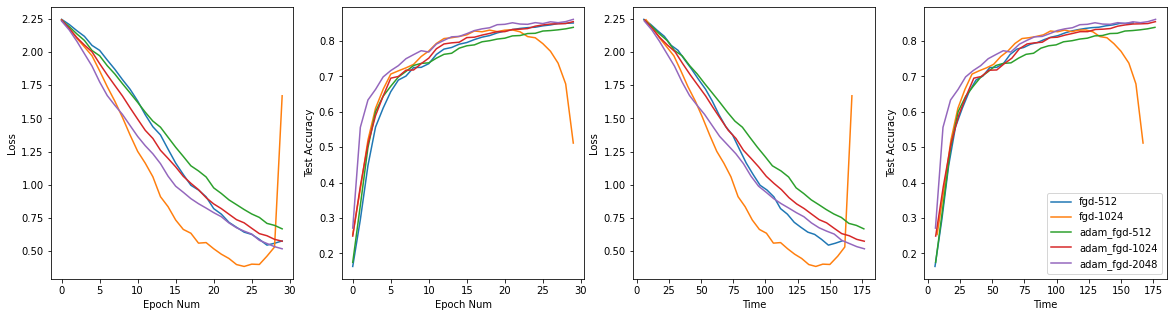

In [ ]:
t_args = {
    "training_generator" : mnist_training_generator,
    "train_data": mnist_train_data,
    "test_data": mnist_test_data,
    "runs": 1} # how many times to run each model -> need to check randomization and keys

mlp_512_args = {
    "train_func": stateful_train_model,
    "grad_func": mlp_fgd_512, 
    "model_func": mlp_predictor_512_t,
    "model_name": "fgd-512",
    "lr": 2e-4,
    "epochs": 30,
}

mlp_1024_args = {
    "train_func": stateful_train_model,
    "grad_func": mlp_fgd_1024, 
    "model_func": mlp_predictor_1024_t,
    "model_name": "fgd-1024",
    "lr": 2e-4,
    "epochs": 30,
}

adam_512_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_fgd_512, 
    "model_func": mlp_predictor_512_t,
    "model_name": "adam_fgd-512",
    "lr": 2e-4,
    "epochs": 30,
}

adam_1024_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_fgd_1024, 
    "model_func": mlp_predictor_1024_t,
    "model_name": "adam_fgd-1024",
    "lr": 2e-4,
    "epochs": 30,
}

adam_2048_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_fgd_2048, 
    "model_func": mlp_predictor_2048_t,
    "model_name": "adam_fgd-2048",
    "lr": 2e-4,
    "epochs": 30,
}

# run_experiment(t_args, [mlp_512_args, mlp_1024_args, adam_512_args, adam_1024_args, adam_2048_args], 'mlp_diff_hyperparams.pkl', 'mlp_diff_hyperparams.png')
# display results w/o rerunning experiments
saved_metrics = load_data(path + 'mlp_diff_hyperparams.pkl')
graph_experiments(saved_metrics, colors=None, has_axs_lables=True)



## Experiment 2: Forward Gradient vs Backprop vs Adam

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

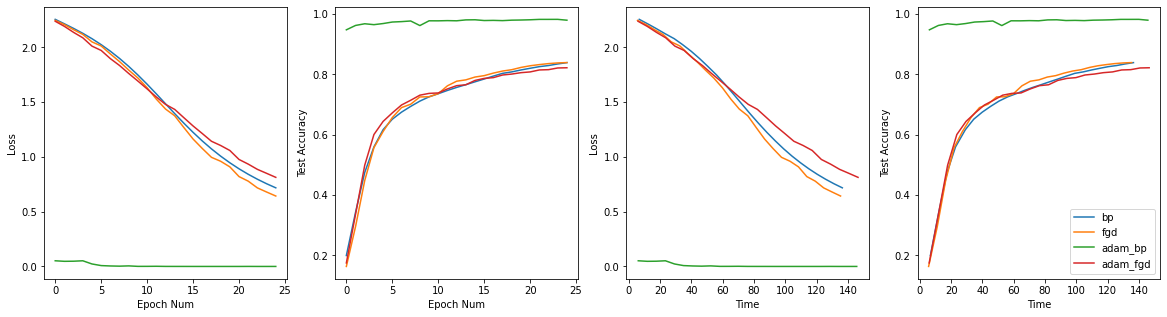

In [ ]:
t_args = {
    "training_generator" : mnist_training_generator,
    "train_data": mnist_train_data,
    "test_data": mnist_test_data,
    "runs": 1} # how many times to run each model

bp_args = {
    "train_func": stateful_train_model,
    "grad_func": mlp_backprop_512, 
    "model_func": mlp_predictor_512_t,
    "model_name": "bp",
    "lr": 2e-4,
    "epochs": 30,
}

fgd_args = {
    "train_func": stateful_train_model,
    "grad_func": mlp_fgd_512, 
    "model_func": mlp_predictor_512_t,
    "model_name": "fgd",
    "lr": 2e-4,
    "epochs": 25,
}

adambp_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_backprop_512, 
    "model_func": mlp_predictor_512_t,
    "model_name": "adam_bp",
    "lr": 2e-4,
    "epochs": 30,
}

adamfgd_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_fgd_512, 
    "model_func": mlp_predictor_512_t,
    "model_name": "adam_fgd",
    "lr": 2e-4,
    "epochs": 25,
}

# run_experiment(t_args, [bp_args, adambp_args], 'bp_adam.pkl', 'bp_adam.png')
graph_dict = load_data('bp_fgd_adam_updated.pkl')
graph_experiments(graph_dict, colors=None, has_axs_lables=True, graph_name='bp_fgd_adam_updated.png')


## Experiment 3, BN with FGD vs BP

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

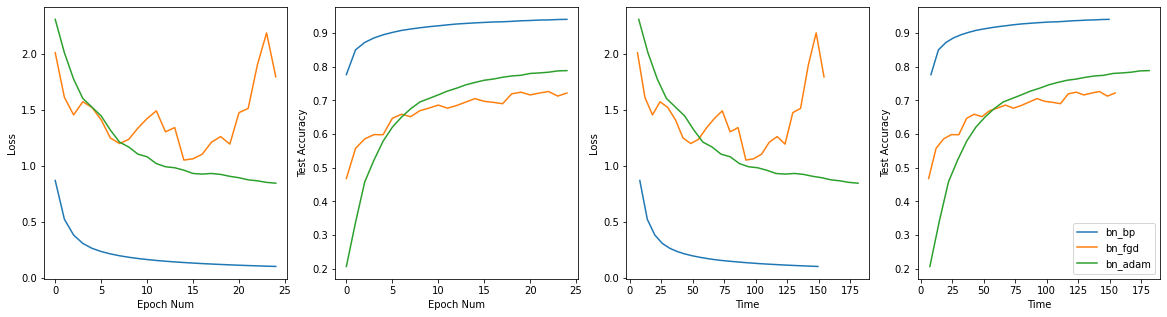

In [ ]:
t_args = {
    "training_generator" : mnist_training_generator,
    "train_data": mnist_train_data,
    "test_data": mnist_test_data,
    "runs": 1} # how many times to run each model

bp_args = {
    "train_func": stateful_train_model,
    "grad_func": mlp_batchnorm_backprop,
    "model_func": mlp_batchnorm_predictor_t,
    "model_name": "bp",
    "lr": 2e-4,
    "epochs": 25,
}

fgd_args = {
    "train_func": stateful_train_model,
    "grad_func": mlp_batchnorm_fgd,
    "model_func": mlp_batchnorm_predictor_t,
    "model_name": "fgd",
    "lr": 2e-4,
    "epochs": 25,
}

adambp_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_batchnorm_backprop,
    "model_func": mlp_batchnorm_predictor_t,
    "model_name": "adam_bp",
    "lr": 2e-4,
    "epochs": 25,
}

adamfgd_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_batchnorm_fgd,
    "model_func": mlp_batchnorm_predictor_t,
    "model_name": "adam_fgd",
    "lr": 2e-4,
    "epochs": 25,
}

# run_experiment(t_args, [bp_args, fgd_args, adambp_args, adamfgd_args], 'bn_new.pkl', 'bn_new.png')
graph_dict = load_data("bn.pkl")
graph_experiments(graph_dict, colors=None, has_axs_lables=True, graph_name='bn_new.png')


## Experiment 4 CIFAR10 MLP, BP vs fgd

 ==================== Training fgd 0 ==================== 
Epoch 0 in 7.79 sec
Training loss 2.2882511615753174 
Training set accuracy 0.11977999657392502
Test set accuracy 0.11977999657392502
Step size 0.000184961361810565
Epoch 1 in 4.04 sec
Training loss 2.2707767486572266 
Training set accuracy 0.1494399905204773
Test set accuracy 0.1494399905204773
Step size 0.0001710536307655275
Epoch 2 in 4.00 sec
Training loss 2.2472498416900635 
Training set accuracy 0.16995999217033386
Test set accuracy 0.16995999217033386
Step size 0.00015819162945263088
Epoch 3 in 3.97 sec
Training loss 2.253936767578125 
Training set accuracy 0.17576000094413757
Test set accuracy 0.17576000094413757
Step size 0.00014629669021815062
Epoch 4 in 3.96 sec
Training loss 2.24935245513916 
Training set accuracy 0.19203999638557434
Test set accuracy 0.19203999638557434
Step size 0.00013529614079743624
Epoch 5 in 3.95 sec
Training loss 2.2562506198883057 
Training set accuracy 0.1918799877166748
Test set accuracy 0

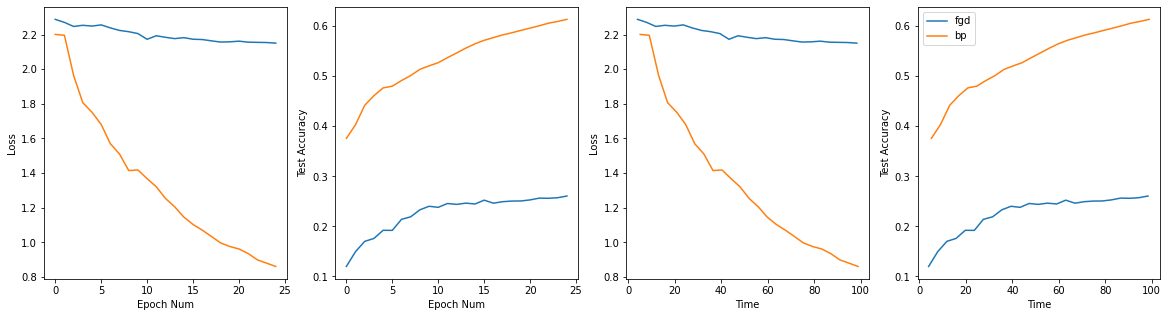

In [ ]:
t_args = {
    "training_generator" : cifar_training_generator,
    "train_data": cifar_train_data,
    "test_data": cifar_test_data,
    "runs": 1} # how many times to run each model

bp_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_backprop_1024, 
    "model_func": mlp_predictor_1024_t,
    "model_name": "bp",
    "lr": 2e-4,
    "epochs": 25,
}

fgd_args = {
    "train_func": train_model_adam,
    "grad_func": mlp_fgd_1024, 
    "model_func": mlp_predictor_1024_t,
    "model_name": "fgd",
    "lr": 2e-4,
    "epochs": 25,
}

run_experiment(t_args, [fgd_args, bp_args, fgd_args,], 'cifar_bp_fgd.pkl')

## Experiment 5, Conv vs ResNet, BP and FGD

One expects to see performance improvements with a ResNet

In [ ]:
t_args = {
    "training_generator" : mnist_training_generator,
    "train_data": mnist_train_data,
    "test_data": mnist_test_data,
    "runs": 1} # how many times to run each model

bp_args = {
    "train_func": stateful_train_model,
    "grad_func": conv_backprop,
    "model_func": conv_predictor_t,
    "model_name": "conv_bp",
    "lr": 2e-5,
    "epochs": 25,
}

fgd_args = {
    "train_func": stateful_train_model,
    "grad_func": conv_fgd,
    "model_func": conv_predictor_t,
    "model_name": "conv_fgd",
    "lr": 2e-5,
    "epochs": 25,
}

res_bp_args = {
    "train_func": stateful_train_model,
    "grad_func": res_backprop,
    "model_func": res_predictor_t,
    "model_name": "res_backprop",
    "lr": 2e-5,
    "epochs": 25,
}

res_fgd_args = {
    "train_func": stateful_train_model,
    "grad_func": res_fgd,
    "model_func": res_predictor_t,
    "model_name": "res_fgd",
    "lr": 2e-5,
    "epochs": 25,
}

run_experiment(t_args, [bp_args, fgd_args, res_bp_args, res_fgd_args], 'res_conv.pkl')


 ==================== Training res_fgd 0 ==================== 
Epoch 0 in 28.71 sec
Training loss 2.241273880004883 
Training set accuracy 0.14745000004768372
Test set accuracy 0.14259999990463257
Step size 0.001998001243919134
Epoch 1 in 5.91 sec
Training loss 2.12831711769104 
Training set accuracy 0.21389999985694885
Test set accuracy 0.21849998831748962
Step size 0.001996004255488515
Epoch 2 in 5.89 sec
Training loss 2.2227723598480225 
Training set accuracy 0.28288334608078003
Test set accuracy 0.2830999791622162
Step size 0.0019940093625336885
Epoch 3 in 5.97 sec
Training loss 2.0968849658966064 
Training set accuracy 0.26179999113082886
Test set accuracy 0.2615000009536743
Step size 0.0019920163322240114
Epoch 4 in 5.91 sec
Training loss 2.3662877082824707 
Training set accuracy 0.3331833481788635
Test set accuracy 0.33739998936653137
Step size 0.001990025397390127
Epoch 5 in 5.88 sec
Training loss 2.286017894744873 
Training set accuracy 0.3371666669845581
Test set accuracy 0.3

FileNotFoundError: ignored

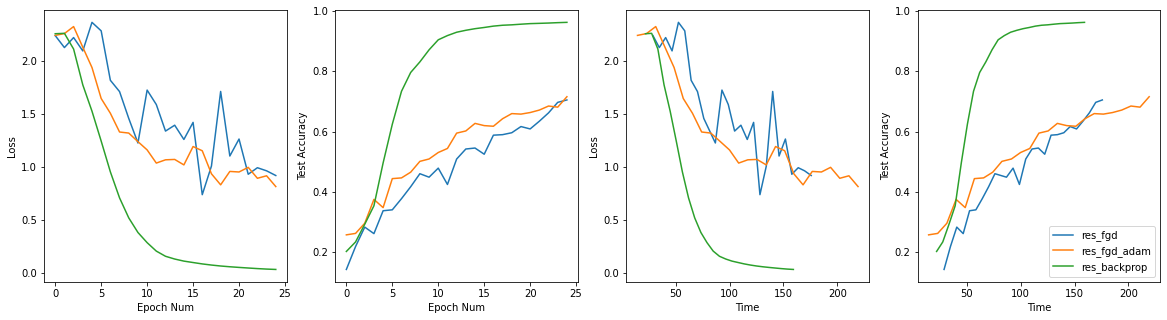

In [ ]:
t_args = {
    "training_generator" : mnist_training_generator,
    "train_data": mnist_train_data,
    "test_data": mnist_test_data,
    "runs": 1} # how many times to run each model
fgd_res_args = {
    "train_func": stateful_train_model,
    "grad_func": res_fgd,
    "model_func": res_predictor_t,
    "model_name": "res_fgd",
    "lr": 2e-3,
    "epochs": 25,
}

adam_res_args = {
    "train_func": train_model_adam,
    "grad_func": res_fgd,
    "model_func": res_predictor_t,
    "model_name": "res_fgd_adam",
    "lr": 2e-3,
    "epochs": 25,
}

bp_res_args = {
    "train_func": stateful_train_model,
    "grad_func": res_backprop,
    "model_func": res_predictor_t,
    "model_name": "res_backprop",
    "lr": 2e-3,
    "epochs": 25,
}
# woops forgot to run resnets in above run
run_experiment(t_args, [fgd_res_args, adam_res_args, bp_res_args,], 'res_bp_adam2.pkl', "res_bp_adam")